Mac 用 Hugging Face 的 diffusers 有很多奇怪的問題, 有些可能是 PyTorch 在 MPS (在 M1/M2 Mac 上加速的方式) 支援還有問題, 有些還不明原因。總之在生命中的某一天也許這些都修好了, 不過在那天來到之前, 要在 Mac 上玩 Stable Diffusion 請參考本篇的作法。

這裡假設安裝好了 PyTorch, 現在在 Anaconda 上安裝這是小事, 請依 [PyTorch 官網](https://pytorch.org/) 給的方式安裝, 很可能是在終端機中下這樣的指令:

    conda install pytorch torchvision torchaudio -c pytorch
    
然後不要忘記需要一些相關套件也裝一下:

    pip install transformers
    pip install diffusers
    pip install sentencepiece

這些都裝好我們就開始吧。

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 1. 準備好我們的 model

首先我們先寫個「拼圖」的小程式。 

In [2]:
from PIL import Image

In [3]:
def combine_imgs(images):
    width, height = images[0].size
    new_img = Image.new('RGB', (width, height))

    w = int(width/2)
    h = int(height/2)

    new_img.paste(images[0].resize((w,h)), (0, 0))
    new_img.paste(images[1].resize((w,h)), (w, 0))
    new_img.paste(images[2].resize((w,h)), (0, h))
    new_img.paste(images[3].resize((w,h)), (w, h))
    return new_img

讀入 `diffusers` 需要的相關套件。

In [4]:
import torch

In [5]:
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler

這段我們用了 `openjourney-v2`, 你可以選你想要的模型。特別注意 Mac 上沒有 `cuda`, 需要改成 `mps`。

In [6]:
pipe = StableDiffusionPipeline.from_pretrained("prompthero/openjourney-v2", torch_dtype=torch.float16)
pipe = pipe.to("mps")

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

/Users/yenlung/anaconda3/envs/pytorch/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


指定我們的 sampler。

In [7]:
pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)

Hugging Face 強列建議, 事實上我們也發現, PyTorch 在 Mac 上很容易發生計憶體不足的情況。所以如果你的 Mac 不是 64G (!!!), 請下達下面這段指令。 

In [8]:
pipe.enable_attention_slicing()

不要以為 Mac 特別的地方結束了, 因為直到現在沒有人知道的原因, Mac 在生第一張圖的時候有點怪怪的。所以這裡我們做個「暖機」的動作。

In [9]:
prompt = 'a happy rabbit'

In [10]:
_ = pipe(prompt, num_inference_steps=1)

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/yenlung/anaconda3/envs/pytorch/lib/python3.10/site-packages/diffusers/schedulers/scheduling_euler_discrete.py:168: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525498485/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  step_index = (self.timesteps == timestep).nonzero().item()
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


順道一提, 在這時你很容易會看到因為偵測可能是 NSFW (上班不要看) 的圖, 所以被黑了。不要以為真的生了本來你可能很想看的圖, 因為我們只做了一步基本上就還是雜訊。

### 2. 進入「真正」生圖程序

如我們「冒險副本03」介紹的方式, 先來生四個 random seeds。你有自己的幸運數字當然可以自己給這 4 個數字。

In [11]:
seeds = np.random.randint(0, 1000000, 4)
seeds = [int(i) for i in seeds]

設我們的 `prompt` 和 `negative_prompt`。

In [12]:
prompt = "a young asian female, highlights in hair, smiling, sitting in a cafe, wearing a dress, side light"

In [13]:
negative_prompt = "ugly"

打造 4 個不同的 generators, 各自用各自的 random seed。注意我們沒有 `cuda`! 沒有 `cuda`!

In [14]:
generator = [torch.Generator().manual_seed(i) for i in seeds]

如果用之前的方式, 我們一次生 4 張圖出來的話, 你會發現生不出來!!! 還很容易產生 NSFW 的警告。大家認為是 PyTorch 在 MPS 支援的問題, 可能要等 PyTorch 的改善。

也就是說, 在生命中的某一天, 你可能可以在 Mac 上直接下達這樣的指令, 但現在還不可以。

In [15]:
#images = pipe(prompt, negative_prompt=negative_prompt, generator=generator, num_images_per_prompt=4).images

很離奇的是, 我們如果不貪心, 每次只生一張圖是可以的。但是你看人家一次生 4 張, 我們只能生一張心情當然不好。目前我們可以做的方式就是用 `for` 迴圈一張一張生。

In [16]:
images = []

num_of_imgs = 4

for i in range(num_of_imgs):
    img = pipe(prompt, negative_prompt=negative_prompt, generator=generator[i]).images[0]
    images.append(img)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

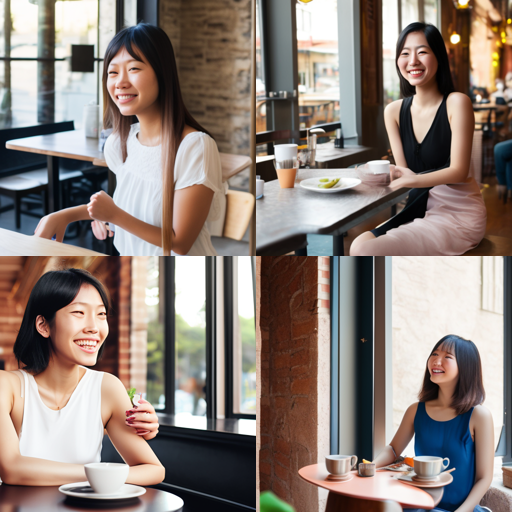

In [17]:
combine_imgs(images)

### 3. 單張修圖

到這裡該說的都說了。現在只是稍稍複習一下, 接下來就可以全部一起修圖, 也可以單張修圖。假設我們要修的圖是第 3 張 (左下角), 也就是 index 是 2 的圖。可以再生一次確認我們真的可以完美控制。

  0%|          | 0/50 [00:00<?, ?it/s]

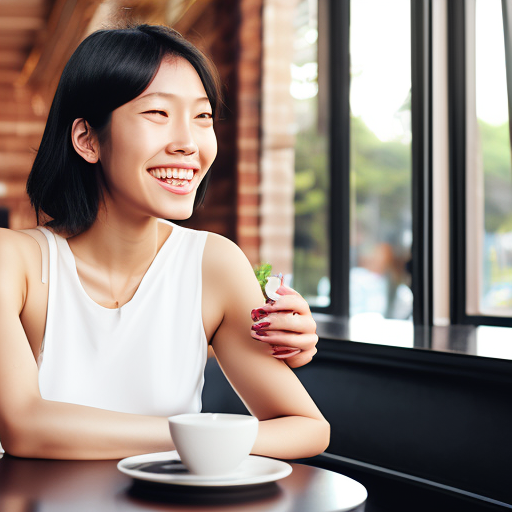

In [21]:
negative_prompt = "ugly"

r = seeds[2]
generator = torch.Generator().manual_seed(r)
image = pipe(prompt, negative_prompt=negative_prompt, generator=generator).images[0]

image

其實我不知道你現在的圖怎麼了, 因為我們是用亂數取 random seed 的, 如果希望看到一樣結果, 這次我們的 `seeds` 是:

    [837219, 431012, 621232, 503596]
    
這裡看到的圖是多了一隻手, 所以我們看看能不能去除。

  0%|          | 0/50 [00:00<?, ?it/s]

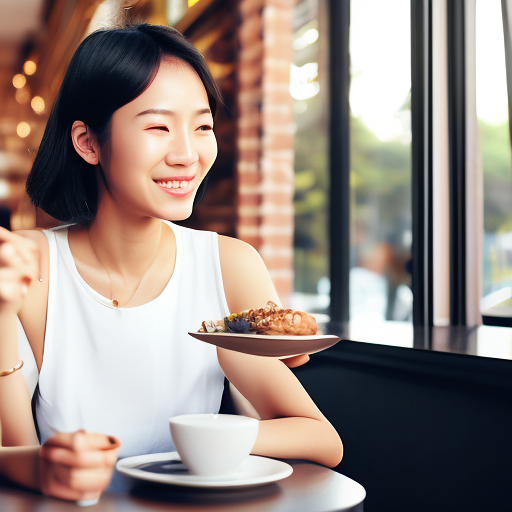

In [22]:
negative_prompt = "ugly, extra limbs"

r = seeds[2]
generator = torch.Generator().manual_seed(r)
image = pipe(prompt, negative_prompt=negative_prompt, generator=generator).images[0]

image

在我們的例子中, 多出的手是除掉了, 但變成超能力少女, 讓一個盤子浮在空中。這後面就讓大家自己慢慢修了。